<a href="https://colab.research.google.com/github/vgorbikov/image_processing/blob/main/02_nn_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Полносвязная (искусственная) нейронная сеть

В этом задании вам предстоит реализовать полносвязную двухслойную нейронную сеть с помощью библиотеки Numpy и применить её для классификации.

Архитектура сети будет выглядеть следующим образом:

Входные данные $→$ Линейный слой $→$ Функция активации $→$ Линейный слой $→$ Softmax $→$ Loss

# 1. Датасет

Для задачи будем использовать датасет CIFAR-10 [[ссылка](https://www.cs.toronto.edu/~kriz/cifar.html)]. Загрузим датасет, приведем значения пикселей к интервалу $[0, 1]$, а также осуществим one-hot кодирование целевого вектора.

Отобразите несколько изображений и соответствующие им классы.

170498071/170498071 [==============================] - 3s 0us/step


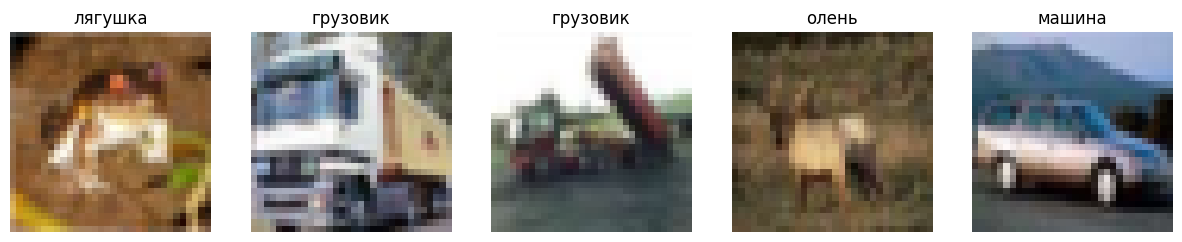

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical


# Загрузка датасета
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.cifar10.load_data()

x_train = (x_train/255.0).astype('float32')
x_val = (x_val/255.0).astype('float32')
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

def flatten_samples(dataset):
  flatset = np.array([sample.flatten() for sample in dataset])
  return flatset

x_train = flatten_samples(x_train)
x_val = flatten_samples(x_val)
y_train = flatten_samples(y_train)
y_val = flatten_samples(y_val)

class_names = ['самолет', 'машина', 'птица', 'кошка', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

# Отобразим несколько изображений с соответствующими классами
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(x_train[i].reshape(32, 32, 3))
    axes[i].set_title(class_names[np.argmax(y_train[i])])
    axes[i].axis('off')

plt.show()

# 2. Реализация слоев нейронной сети
В этом пункте необходимо реализовать forward pass и backward pass для используемых слоев. Функции должны возвращать либо результат действия слоя на входные данные, либо, если `get_grad=True`, градиент(ы).

1. **Линейный слой**
$$ f(x, W, b) = xW + b $$


In [ ]:
def linear(x, W, b, get_grad=False):
    if get_grad:
        grad = (W, x.T, np.ones(x.shape[0]))
        return grad
    else:
        output = x @ W + b
        return output

2. **ReLU**

$$ ReLU(x) = max(x, 0)$$
В качестве функции активации будем использовать ReLU; напишите функцию, реализующую его работу.

In [ ]:
def relu(x, get_grad=False):
    if get_grad:
        grad = np.where(x > 0, 1, 0)
        return grad
    else:
        return np.maximum(0, x)

3. **Softmax + Cross-entropy loss**

$$s_i(x) = \frac{e^{x_i}}{\sum\limits_{j}^K e^{x_j}} $$
$$CE(y, \hat{y}) = - \frac{1}{N}\sum\limits_i^N \sum\limits_j^K y_j \ln\hat{y_j}$$
где $K-$количество классов, $N-$ количество объектов.

Если мы используем Softmax вместе с функцией потерь в виде кросс-энтропии, то удобно объединить их вместе в один слой из-за удобства получаемых выражений. Напишите выражения для функции потерь и для градиента (можно без полного вывода) и реализуйте функцию аналогичную прошлому пункту.

In [ ]:
def softmax(x):
    exps = np.exp(x - np.max(x))
    softmax = exps / (np.sum(exps, axis=1))[:,None]
    return softmax

def softmax_ce(y_true, x, get_grad=False):
    exps = np.exp(x - np.max(x))
    softmax = exps / (np.sum(exps, axis=1))[:,None]
    if get_grad:
        return softmax - y_true
    else:
        loss = -np.sum(y_true * np.log(softmax)) / len(y_true)
        return loss

# 3. Обучение
До начала обучения необходимо сделать еще несколько шагов:

- **Инициализация весов**. Начальные значения матриц весов могут сильно влиять на ход обучения. Инициализируйте матрицы $W$ и $b$ случайными числами из нормального распределения.
- Выбор **темпа обучения (learning rate)**. Гиперпараметр, отвечающий за размер шага в алгоритме градиентного спуска.
- Выбор **количества нейронов в скрытом слое**
- **Размер батча**. В глубоком обучении через нейронную сеть редко пропускают сразу весь датасет. Вместо этого входные данные делят на части, которые называются **батчи (batch)**, и пропускают по очереди через сеть, обновляя веса после каждой итерации. Когда все батчи из датасета были использованы для forward и backward проходов, заканчивается **эпоха обучения**.

    Такой подход позволяет избежать проблем с памятью (датасет может не помещаться в память целиком), а также улучшить сходимость (обновляем веса после каждого батча, а не только один раз после прохода всего датасета).

    Выберите размер батча и разбейте датасет на части.

In [ ]:
NUM_EPOCH = 10
BATCH_SIZE = 50

INPUT_SIZE = 32 * 32 * 3 # размер картинки
HIDDEN_SIZE = 128
OUTPUT_SIZE = 10 # 10 классов
LR = 0.001



def initialize_weights(input_size, hidden_size, output_size):
    W1 = np.random.randn(input_size, hidden_size) * 0.01
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) * 0.01
    b2 = np.zeros((1, output_size))

    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}



def get_batches(X, y, batch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start in range(0, len(indices), batch_size):
        end = min(start + batch_size, len(indices))
        batch_indices = indices[start:end]
        yield X[batch_indices], y[batch_indices]


total_epoch_count = 0
loss_train = []
acc_train = []
weights = initialize_weights(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

Реализуйте процесс обучения сети с заданными параметрами. В конце каждой эпохи выводите значения тренировочного и валидационного **лосса**, а также метрики
**Accuracy**. В конце обучения постройте зависимости лоссов и метрик от номера эпохи.

Вам необходимо достичь значения Accuracy на валидационном датасете в 50% или более.

EPOCH 31
	 train_loss: 1.1860831459724812; train_accuracy 0.5802000000000003; val_accuracy: 0.508
EPOCH 32
	 train_loss: 1.1830675468189262; train_accuracy 0.5835200000000009; val_accuracy: 0.5018
EPOCH 33
	 train_loss: 1.173297971473643; train_accuracy 0.5849000000000011; val_accuracy: 0.4537
EPOCH 34
	 train_loss: 1.163485556859744; train_accuracy 0.5877400000000004; val_accuracy: 0.5081
EPOCH 35
	 train_loss: 1.1559677814322293; train_accuracy 0.5906200000000009; val_accuracy: 0.4897
EPOCH 36
	 train_loss: 1.1475972004628963; train_accuracy 0.5939400000000005; val_accuracy: 0.516
EPOCH 37
	 train_loss: 1.1383449693341139; train_accuracy 0.5969200000000005; val_accuracy: 0.4934
EPOCH 38
	 train_loss: 1.1361894549260376; train_accuracy 0.5977600000000006; val_accuracy: 0.5155
EPOCH 39
	 train_loss: 1.1300151827345586; train_accuracy 0.5992800000000015; val_accuracy: 0.5045
EPOCH 40
	 train_loss: 1.1201106373948027; train_accuracy 0.6013600000000003; val_accuracy: 0.5169


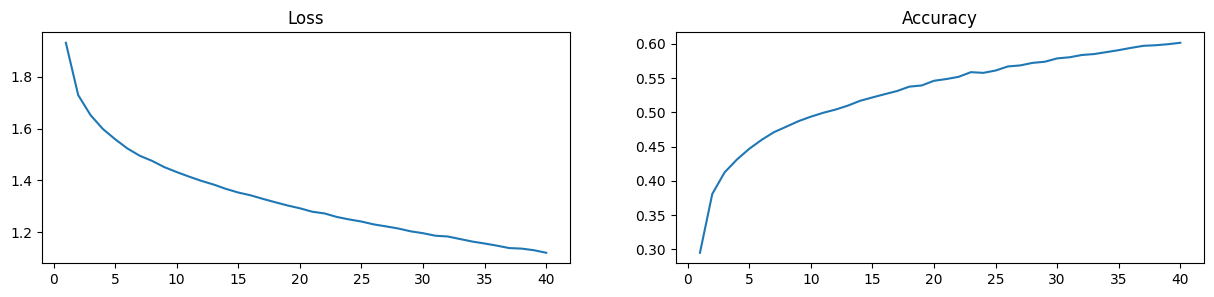

Проверка на валидационных данных, точность: 0.5169


In [ ]:
def accuracy(true, pred):
    correctly_pred = 0
    for i in range(len(true)):
        if pred[i] == true[i]:
            correctly_pred += 1
    return correctly_pred / len(true)



for epoch in range(NUM_EPOCH):
    accuracy_batch = []
    loss_batch = []

    for X_batch, y_batch in get_batches(x_train, y_train, BATCH_SIZE):
        # Forward pass
        linear1_out= linear(X_batch, weights['W1'], weights['b1'])
        relu_out = relu(linear1_out)
        linear2_out = linear(relu_out, weights['W2'], weights['b2'])

        accuracy_batch.append(accuracy(np.argmax(y_batch, axis=1), np.argmax(softmax(linear2_out), axis=1)))

        loss_batch.append(softmax_ce(y_batch, linear2_out))

        # Backward pass
        grad_loss = softmax_ce(y_batch, linear2_out, get_grad=True)
        grad_out_x, grad_out_W, grad_out_b = linear(relu_out, weights['W2'], weights['b2'], get_grad=True)
        grad_h_relu = relu(linear(X_batch, weights['W1'], weights['b1']), get_grad=True)
        grad_h_x, grad_h_W, grad_h_b = linear(X_batch, weights['W1'], weights['b1'], get_grad=True)

        # Update weights
        weights['W1'] -= grad_h_W @ (grad_h_relu * (grad_loss @ grad_out_x.T)) * LR
        weights['b1'] -= grad_h_b @ (grad_h_relu * (grad_loss @ grad_out_x.T)) * LR
        weights['W2'] -= grad_out_W @ grad_loss * LR
        weights['b2'] -= grad_out_b @ grad_loss * LR


    loss_train.append(sum(loss_batch) / len(loss_batch))
    acc_train.append(sum(accuracy_batch)/len(accuracy_batch))

    result_linear1_out= linear(x_val, weights['W1'], weights['b1'])
    result_relu_out = relu(result_linear1_out)
    result_linear2_out = linear(result_relu_out, weights['W2'], weights['b2'])
    result_loss = softmax(result_linear2_out)

    print(f"EPOCH {total_epoch_count + 1}\n\t train_loss: {sum(loss_batch) / len(loss_batch)}; train_accuracy {sum(accuracy_batch) / len(accuracy_batch)}; val_accuracy: {accuracy(np.argmax(y_val, axis=1), np.argmax(result_loss, axis=1))}")
    total_epoch_count+=1



fig, axes = plt.subplots(1, 2, figsize=(15, 3))

axes[0].plot(range(1, total_epoch_count + 1), loss_train)
axes[0].set_title('Loss')
axes[1].plot(range(1, total_epoch_count + 1), acc_train)
axes[1].set_title('Accuracy')

plt.show()



result_linear1_out= linear(x_val, weights['W1'], weights['b1'])
result_relu_out = relu(result_linear1_out)
result_linear2_out = linear(result_relu_out, weights['W2'], weights['b2'])
result_loss = softmax(result_linear2_out)


print(f"Проверка на валидационных данных, точность: {accuracy(np.argmax(y_val, axis=1), np.argmax(result_loss, axis=1))}")

## **Перед отправкой сохраните ноутбук с именем в следующем формате: 02_Фамилия.ipynb**

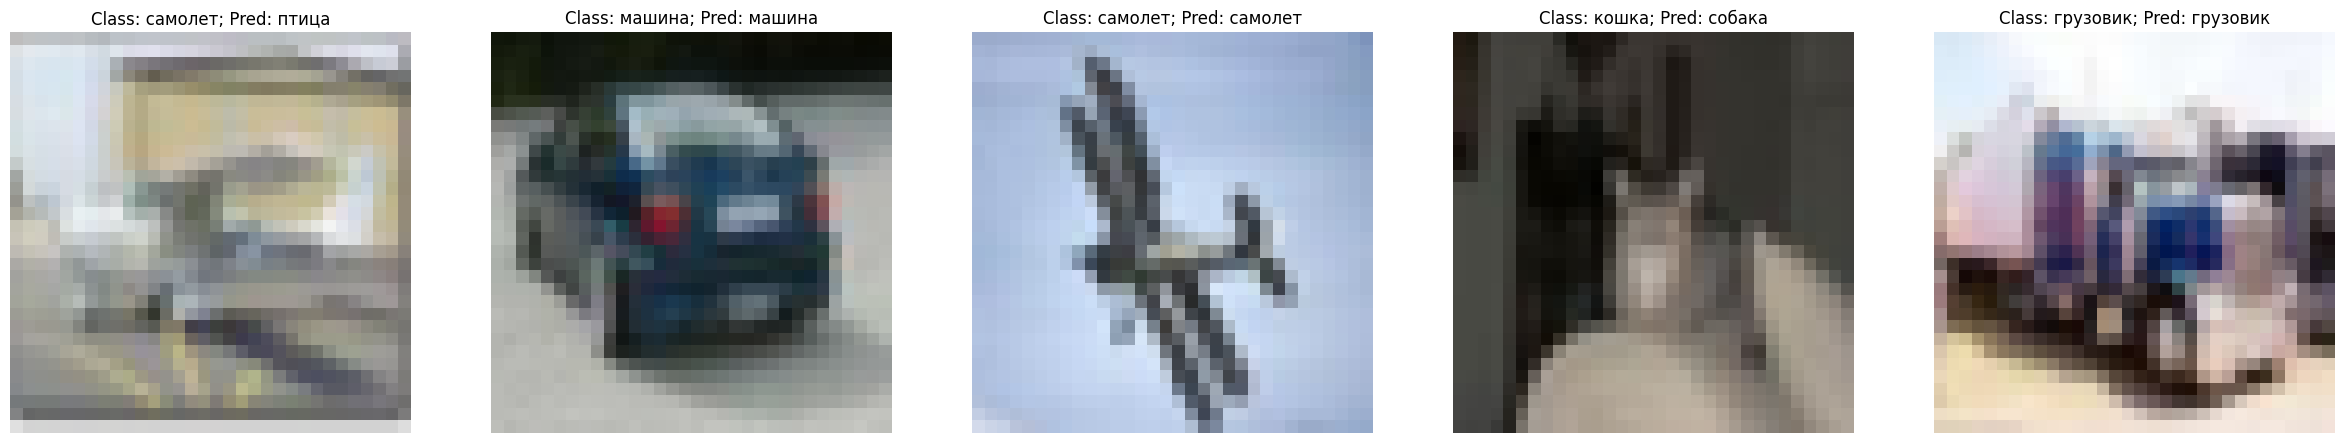

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(30, 6))

result_linear1_presentation = linear(x_val, weights['W1'], weights['b1'])
result_relu_presentation = relu(result_linear1_out)
result_linear2_presentation = linear(result_relu_out, weights['W2'], weights['b2'])
result_presentation = softmax(result_linear2_out)

for i in range(5):
    indexes = np.random.randint(0, len(y_val), 5)
    axes[i].imshow(x_val[indexes[i]].reshape(32, 32, 3))
    axes[i].set_title(f'Class: {class_names[np.argmax(y_val[indexes[i]])]}; Pred: {class_names[np.argmax(result_presentation[indexes[i]])]}')
    axes[i].axis('off')

plt.show()

В целом не так уж плохо :)